In [1]:
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np



AMBIL DATA DARI YAHOO FINANCE

In [2]:
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]

today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-05-31'

panel_data = data.DataReader(tickers,'yahoo',start_date, end_date)
panel_data.head(5)x


Attributes    Adj Close                                               Close  \
Symbols         ANTM.JK      ASII.JK      ICBP.JK      JSMR.JK      ANTM.JK   
Date                                                                          
2010-01-04  1576.277222  2454.149414  1443.428345  1530.938110  1931.946777   
2010-01-05  1576.277222  2468.053467  1472.885864  1547.488525  1931.946777   
2010-01-06  1576.277222  2454.149414  1463.066772  1555.763794  1931.946777   
2010-01-07  1610.544189  2377.674072  1472.885864  1547.488525  1973.945557   
2010-01-08  1610.544189  2391.578613  1482.705200  1539.213257  1973.945557   

Attributes                                      High          ...     Low  \
Symbols    ASII.JK ICBP.JK      JSMR.JK      ANTM.JK ASII.JK  ... ICBP.JK   
Date                                                          ...           
2010-01-04  3530.0  1837.5  1845.677368  1931.946777  3550.0  ...  1762.5   
2010-01-05  3550.0  1875.0  1865.630737  1994.945068  3570.0  ...  1825.0   
2010-01-06  3530.0  1862.5  1875.607300  1994.945068  3580.0  ...  1862.5   
2010-01-07  3420.0  1875.0  1865.630737  1994.945068  3560.0  ...  1862.5   
2010-01-08  3440.0  1887.5  1855.654053  1994.945068  3450.0  ...  1862.5   

Attributes                      Open                                   Volume  \
Symbols         JSMR.JK      ANTM.JK ASII.JK ICBP.JK      JSMR.JK     ANTM.JK   
Date                                                                            
2010-01-04  1805.770874  1931.946777  3530.0  1787.5  1845.677368  39619544.0   
2010-01-05  1845.677368  1931.946777  3550.0  1875.0  1865.630737  62041590.0   
2010-01-06  1855.654053  1931.946777  3530.0  1900.0  1875.607300  30916328.0   
2010-01-07  1845.677368  1973.945557  3420.0  1875.0  1865.630737  30624653.0   
2010-01-08  1845.677368  1973.945557  3440.0  1900.0  1855.654053  15857579.0   

Attributes                                 
Symbols    ASII.JK     ICBP.JK    JSMR.JK  
Date                                       
2010-01-04    40.0  26442000.0  6978806.0  
2010-01-05    40.0  42874000.0  7988164.0  
2010-01-06    40.0  44946000.0  7538113.0  
2010-01-07    40.0  24863000.0  2048787.0  
2010-01-08    40.0  19118000.0  2441705.0  

[5 rows x 24 columns]

In [3]:
data_close = panel_data["Close"]
data_close.head(5).round(2)

Symbols,ANTM.JK,ASII.JK,ICBP.JK,JSMR.JK
Date,,,,
2010-01-04,1931.95,3530.0,1837.5,1845.68
2010-01-05,1931.95,3550.0,1875.0,1865.63
2010-01-06,1931.95,3530.0,1862.5,1875.61
2010-01-07,1973.95,3420.0,1875.0,1865.63
2010-01-08,1973.95,3440.0,1887.5,1855.65


### Deskripsi Data

In [4]:
data_close.describe().round(2)

Symbols,ANTM.JK,ASII.JK,ICBP.JK,JSMR.JK
count,3073.00,3073.00,3073.00,3073.00
mean,1178.16,6688.56,6745.44,4787.32
std,603.01,1202.76,2861.54,1181.79
min,287.00,3280.00,1675.00,1686.05
25%,760.00,5850.00,4050.00,3980.00
50%,955.00,6900.00,7550.00,4870.00
75%,1595.96,7600.00,8850.00,5686.68
max,3190.00,9150.00,12400.00,7183.18


Ploting Data saham

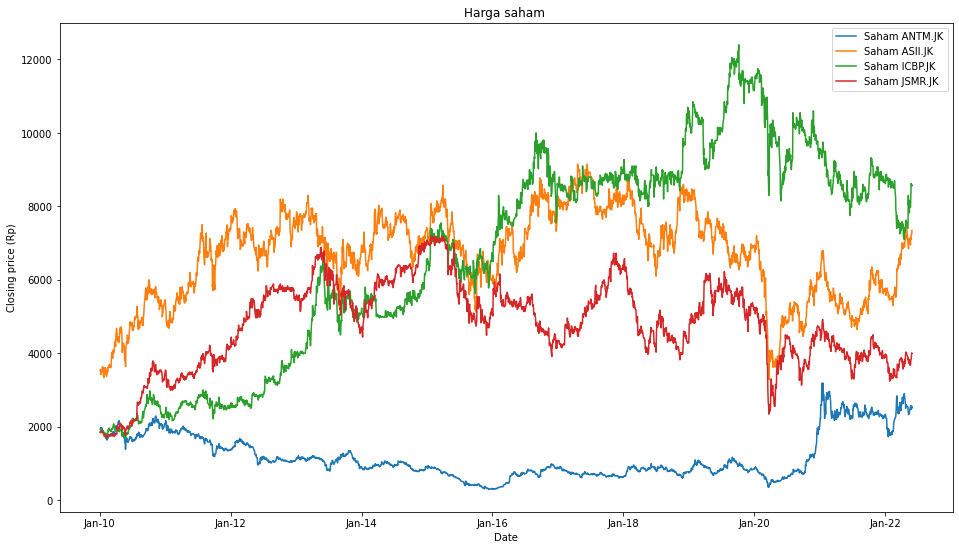

In [5]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

for name in tickers:
    ax.plot(data_close[name].index, data_close[name], label='Saham {}'.format(name))


# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

### CHANGE COLUMN NAMES

In [6]:
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close

,antm,asii,icbp,jsmr
Date,,,,
2010-01-04,1931.946777,3530.0,1837.5,1845.677368
2010-01-05,1931.946777,3550.0,1875.0,1865.630737
2010-01-06,1931.946777,3530.0,1862.5,1875.607300
2010-01-07,1973.945557,3420.0,1875.0,1865.630737
2010-01-08,1973.945557,3440.0,1887.5,1855.654053
...,...,...,...,...
2022-05-24,2570.000000,7150.0,8150.0,3720.000000
2022-05-25,2490.000000,7100.0,8250.0,3800.000000
2022-05-27,2470.000000,7225.0,8625.0,3850.000000


## Normalise Data

In [7]:
df_antm = pd.DataFrame(data_close.antm)
df_asii = pd.DataFrame(data_close.asii)
df_icbp = pd.DataFrame(data_close.icbp)
df_jsmr = pd.DataFrame(data_close.jsmr)

In [8]:
# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_antm = pd.DataFrame(scaler.fit_transform(df_antm), columns = ['antm'])
df_asii = pd.DataFrame(scaler.fit_transform(df_asii), columns = ['asii'])
df_icbp = pd.DataFrame(scaler.fit_transform(df_icbp), columns = ['icbp'])
df_jsmr = pd.DataFrame(scaler.fit_transform(df_jsmr), columns = ['jsmr'])



In [9]:
# convert to windowed data sets
ylist_antm = list(df_antm['antm'])
ylist_asii = list(df_asii['asii'])
ylist_icbp = list(df_icbp['icbp'])
ylist_jsmr = list(df_jsmr['jsmr'])

In [10]:
#LAGS and PERIOD
n_future = 6
n_past = 3*6
total_period = 4*6

## PREPARING DATASET

### ANTM DATASET

In [11]:
idx_end_antm = len(ylist_antm)
idx_start_antm = idx_end_antm - total_period

X_new_antm = []
y_new_antm = []

while idx_start_antm > 0:
  x_line_antm = ylist_antm[idx_start_antm:idx_start_antm+n_past]
  y_line_antm = ylist_antm[idx_start_antm+n_past:idx_start_antm+total_period]

  X_new_antm.append(x_line_antm)
  y_new_antm.append(y_line_antm)

  idx_start_antm = idx_start_antm - 1

import numpy as np
X_new_antm = np.array(X_new_antm)
y_new_antm = np.array(y_new_antm)

# train test split
from sklearn.model_selection import train_test_split
X_train_antm, X_test_antm, y_train_antm, y_test_antm = train_test_split(X_new_antm, y_new_antm, test_size=0.33, random_state=42)

# reshape data into the right format for RNNs
n_samples = X_train_antm.shape[0]
n_timesteps = X_train_antm.shape[1]
n_steps = y_train_antm.shape[1]
n_features = 1

X_train_rs_antm = X_train_antm.reshape(n_samples, n_timesteps, n_features )
X_test_rs_antm = X_test_antm.reshape(X_test_antm.shape[0], n_timesteps, n_features )


### ASII DATASET

In [12]:
idx_end_asii = len(ylist_asii)
idx_start_asii = idx_end_asii - total_period

X_new_asii = []
y_new_asii = []

while idx_start_asii > 0:
  x_line_asii = ylist_asii[idx_start_asii:idx_start_asii+n_past]
  y_line_asii = ylist_asii[idx_start_asii+n_past:idx_start_asii+total_period]

  X_new_asii.append(x_line_asii)
  y_new_asii.append(y_line_asii)

  idx_start_asii = idx_start_asii - 1

import numpy as np
X_new_asii = np.array(X_new_asii)
y_new_asii = np.array(y_new_asii)

# train test split
from sklearn.model_selection import train_test_split
X_train_asii, X_test_asii, y_train_asii, y_test_asii = train_test_split(X_new_asii, y_new_asii, test_size=0.33, random_state=42)

# reshape data into the right format for RNNs
n_samples = X_train_asii.shape[0]
n_timesteps = X_train_asii.shape[1]
n_steps = y_train_asii.shape[1]
n_features = 1

X_train_rs_asii = X_train_asii.reshape(n_samples, n_timesteps, n_features )
X_test_rs_asii = X_test_asii.reshape(X_test_asii.shape[0], n_timesteps, n_features )

### ICBP DATASET

In [13]:
idx_end_icbp = len(ylist_icbp)
idx_start_icbp = idx_end_icbp - total_period

X_new_icbp = []
y_new_icbp = []

while idx_start_icbp > 0:
  x_line_icbp = ylist_icbp[idx_start_icbp:idx_start_icbp+n_past]
  y_line_icbp = ylist_icbp[idx_start_icbp+n_past:idx_start_icbp+total_period]

  X_new_icbp.append(x_line_icbp)
  y_new_icbp.append(y_line_icbp)

  idx_start_icbp = idx_start_icbp - 1

import numpy as np
X_new_icbp = np.array(X_new_icbp)
y_new_icbp = np.array(y_new_icbp)

# train test split
from sklearn.model_selection import train_test_split
X_train_icbp, X_test_icbp, y_train_icbp, y_test_icbp = train_test_split(X_new_icbp, y_new_icbp, test_size=0.33, random_state=42)

# reshape data into the right format for RNNs
n_samples = X_train_icbp.shape[0]
n_timesteps = X_train_icbp.shape[1]
n_steps = y_train_icbp.shape[1]
n_features = 1

X_train_rs_icbp = X_train_icbp.reshape(n_samples, n_timesteps, n_features )
X_test_rs_icbp = X_test_icbp.reshape(X_test_icbp.shape[0], n_timesteps, n_features )

### JSMR DATASET

In [14]:
idx_end_jsmr = len(ylist_jsmr)
idx_start_jsmr = idx_end_jsmr - total_period

X_new_jsmr = []
y_new_jsmr = []

while idx_start_jsmr > 0:
  x_line_jsmr = ylist_jsmr[idx_start_jsmr:idx_start_jsmr+n_past]
  y_line_jsmr = ylist_jsmr[idx_start_jsmr+n_past:idx_start_jsmr+total_period]

  X_new_jsmr.append(x_line_jsmr)
  y_new_jsmr.append(y_line_jsmr)

  idx_start_jsmr = idx_start_jsmr - 1

import numpy as np
X_new_jsmr = np.array(X_new_jsmr)
y_new_jsmr = np.array(y_new_jsmr)

# train test split
from sklearn.model_selection import train_test_split
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(X_new_jsmr, y_new_jsmr, test_size=0.33, random_state=42)

# reshape data into the right format for RNNs
n_samples = X_train_jsmr.shape[0]
n_timesteps = X_train_jsmr.shape[1]
n_steps = y_train_jsmr.shape[1]
n_features = 1

X_train_rs_jsmr = X_train_jsmr.reshape(n_samples, n_timesteps, n_features )
X_test_rs_jsmr = X_test_jsmr.reshape(X_test_jsmr.shape[0], n_timesteps, n_features )

# LSTM SECTION

### ANTM SECTION

In [15]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_one_antm = Sequential([
  LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_antm.shape[1]),
])

simple_model_one_antm.summary()

simple_model_one_antm.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=[
           'mae',
           ],
)

smod_history_one_antm = simple_model_one_antm.fit(X_train_rs_antm, y_train_antm,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

preds_one_antm = simple_model_one_antm.predict(X_test_rs_antm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 6)                 54        
                                                                 
Total params: 374
Trainable params: 374
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 [==============================] - 3s 21ms/step - loss: 0.0763 - mae: 0.0763 - val_loss: 0.0229 - val_mae: 0.0229
Epoch 2/100
52/52 [==============================] - 0s 9ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0241 - val_mae: 0.0241
Epoch 3/100
52/52 [==============================] - 1s 11ms/step - loss: 0.0198 - mae: 0.0198 - val_loss: 0.0180 - val_mae: 0.0180
Epoch 4/100
52/52 [==============================] - 0s 9ms

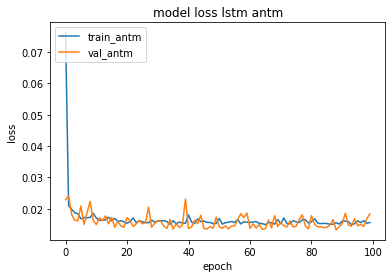

In [54]:
#Summarize model loss
plt.plot(smod_history_one_antm.history['loss'])
plt.plot(smod_history_one_antm.history['val_loss'])
plt.title('model loss lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_antm', 'val_antm'], loc='upper left')
plt.savefig('lstm_one_antm',dpi=1200)

### ASII SECTION

In [17]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_one_asii = Sequential([
   LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_asii.shape[1]),
])

simple_model_one_asii.summary()

simple_model_one_asii.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

smod_history_one_asii = simple_model_one_asii.fit(X_train_rs_asii, y_train_asii,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

preds_one_asii = simple_model_one_asii.predict(X_test_rs_asii)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
Total params: 374
Trainable params: 374
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 [==============================] - 3s 16ms/step - loss: 0.1585 - mae: 0.1585 - val_loss: 0.0415 - val_mae: 0.0415
Epoch 2/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0399 - mae: 0.0399 - val_loss: 0.0402 - val_mae: 0.0402
Epoch 3/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0397 - mae: 0.0397 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 4/100
52/52 [==============================] - 0s 8m

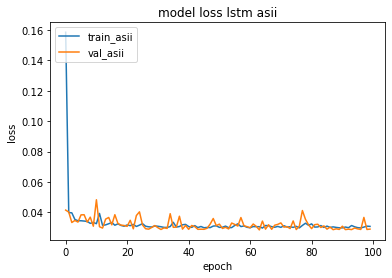

In [53]:
#Summarize model loss
plt.plot(smod_history_one_asii.history['loss'])
plt.plot(smod_history_one_asii.history['val_loss'])
plt.title('model loss lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_asii', 'val_asii'], loc='upper left')
plt.savefig('lstm_one_asii',dpi=1200)

### ICBP SECTION

In [19]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_one_icbp = Sequential([
   LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_icbp.shape[1]),
])

simple_model_one_icbp.summary()

simple_model_one_icbp.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
    metrics=['mae'],
)

smod_history_one_icbp = simple_model_one_icbp.fit(X_train_rs_icbp, y_train_icbp,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

preds_one_icbp = simple_model_one_icbp.predict(X_test_rs_icbp)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_2 (Dense)             (None, 6)                 54        
                                                                 
Total params: 374
Trainable params: 374
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 [==============================] - 3s 18ms/step - loss: 0.0903 - mae: 0.0903 - val_loss: 0.0269 - val_mae: 0.0269
Epoch 2/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0204 - val_mae: 0.0204
Epoch 3/100
52/52 [==============================] - 0s 9ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0159 - val_mae: 0.0159
Epoch 4/100
52/52 [==============================] - 0s 9m

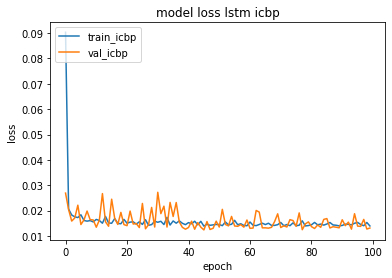

In [52]:
#Summarize model loss
plt.plot(smod_history_one_icbp.history['loss'])
plt.plot(smod_history_one_icbp.history['val_loss'])
plt.title('model loss lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_icbp', 'val_icbp'], loc='upper left')
plt.savefig('lstm_one_icbp',dpi=1200)

### JSMR SECTION

In [21]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_one_jsmr = Sequential([
   LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_jsmr.shape[1]),
])

simple_model_one_jsmr.summary()

simple_model_one_jsmr.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
   metrics=['mae','mape','mse'],
)

smod_history_one_jsmr = simple_model_one_jsmr.fit(X_train_rs_jsmr, y_train_jsmr,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

preds_one_jsmr = simple_model_one_jsmr.predict(X_test_rs_jsmr)




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8)                 320       
                                                                 
 dense_3 (Dense)             (None, 6)                 54        
                                                                 
Total params: 374
Trainable params: 374
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 [==============================] - 3s 17ms/step - loss: 0.1506 - mae: 0.1506 - mape: 72023.5469 - mse: 0.0628 - val_loss: 0.0459 - val_mae: 0.0459 - val_mape: 27.5540 - val_mse: 0.0034
Epoch 2/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0334 - mae: 0.0334 - mape: 43988.4766 - mse: 0.0020 - val_loss: 0.0309 - val_mae: 0.0309 - val_mape: 18.0770 - val_mse: 0.0017
Epoch 3/100
52/52 [============================

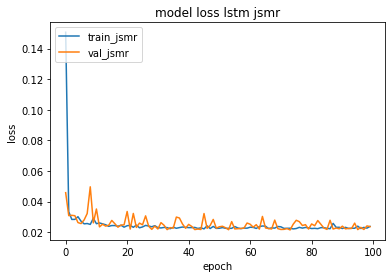

In [51]:
#Summarize model loss
plt.plot(smod_history_one_jsmr.history['loss'])
plt.plot(smod_history_one_jsmr.history['val_loss'])
plt.title('model loss lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_jsmr', 'val_jsmr'], loc='upper left')
plt.savefig('lstm_one_jsmr')

### PLOT COMPARISON (1 layer)

#### MODEL LOSS COMPARISON

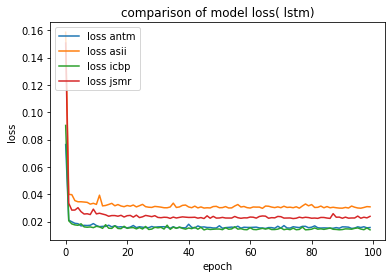

In [57]:
plt.plot(smod_history_one_antm.history['loss'], label='loss antm')
plt.plot(smod_history_one_asii.history['loss'], label = 'loss asii')
plt.plot(smod_history_one_icbp.history['loss'], label = 'loss icbp' )
plt.plot(smod_history_one_jsmr.history['loss'], label = 'loss jsmr')
plt.title('comparison of model loss( lstm)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_comparison_one_lstm', dpi=1200)

### METRICS EVALUATION (1 layer)

#### MAPE

In [38]:
from sklearn.metrics import mean_absolute_percentage_error
# Forecast
# mape score
print("mape score antm: "+str(mean_absolute_percentage_error(preds_one_antm, y_test_antm).round(2)))
print("mape score asii: "+str(mean_absolute_percentage_error(preds_one_asii, y_test_asii).round(2)))
print("mape score icbp: "+str(mean_absolute_percentage_error(preds_one_icbp, y_test_icbp).round(2)))
print("mape score jsmr: "+str(mean_absolute_percentage_error(preds_one_jsmr, y_test_jsmr).round(2)))

mape score antm: 0.09
mape score asii: 0.07
mape score icbp: 0.07
mape score jsmr: 0.06


#### MAE

In [39]:
from sklearn.metrics import mean_absolute_error

# R2 score
print("mae score antm: "+str(mean_absolute_error(preds_one_antm, y_test_antm).round(2)))
print("mae score asii: "+str(mean_absolute_error(preds_one_asii, y_test_asii).round(2)))
print("mae score icbp: "+str(mean_absolute_error(preds_one_icbp, y_test_icbp).round(2)))
print("mae score jsmr: "+str(mean_absolute_error(preds_one_jsmr, y_test_jsmr).round(2)))


mae score antm: 0.02
mae score asii: 0.03
mae score icbp: 0.01
mae score jsmr: 0.02


In [37]:
from sklearn.metrics import r2_score

# R2 score
print("r2 score antm: "+str(r2_score(preds_one_antm, y_test_antm).round(2)))
print("r2 score asii: "+str(r2_score(preds_one_asii, y_test_asii).round(2)))
print("r2 score icbp: "+str(r2_score(preds_one_icbp, y_test_icbp).round(2)))
print("r2 score jsmr: "+str(r2_score(preds_one_jsmr, y_test_jsmr).round(2)))


r2 score antm: 0.98
r2 score asii: 0.96
r2 score icbp: 0.99
r2 score jsmr: 0.97


# RNN SECTION

In [29]:
import random
random.seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

simple_model_rnn_one_antm = Sequential([
  SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_antm.shape[1]),
])


simple_model_rnn_one_antm.summary()

simple_model_rnn_one_antm.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_rnn_one_antm = simple_model_rnn_one_antm.fit(X_train_rs_antm, y_train_antm,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

preds_rnn_one_antm = simple_model_rnn_one_antm.predict(X_test_rs_antm)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense_4 (Dense)             (None, 6)                 54        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 [==============================] - 2s 11ms/step - loss: 0.1039 - mean_absolute_error: 0.1039 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 2/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0255 - mean_absolute_error: 0.0255 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 3/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0214 - mean_absolute_error: 0.0214 - val_loss: 0.0

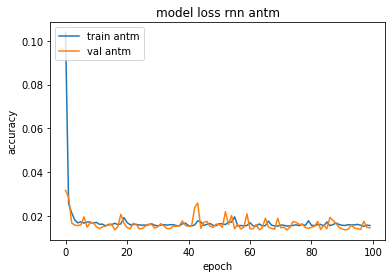

In [50]:
import matplotlib.pyplot as plt
plt.plot(smod_history_rnn_one_antm.history['loss'])
plt.plot(smod_history_rnn_one_antm.history['val_loss'])
plt.title('model loss rnn antm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train antm', 'val antm'], loc='upper left')
plt.savefig('rnn_one_antm')
plt.show()

### ASII

In [31]:
import random
random.seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

simple_model_rnn_one_asii = Sequential([
  SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_asii.shape[1]),
])


simple_model_rnn_one_asii.summary()

simple_model_rnn_one_asii.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_rnn_one_asii = simple_model_rnn_one_asii.fit(X_train_rs_asii, y_train_asii,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

preds_rnn_one_asii = simple_model_rnn_one_asii.predict(X_test_rs_asii)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_5 (Dense)             (None, 6)                 54        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 [==============================] - 2s 9ms/step - loss: 0.1030 - mean_absolute_error: 0.1030 - val_loss: 0.0568 - val_mean_absolute_error: 0.0568
Epoch 2/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0397 - mean_absolute_error: 0.0397 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405
Epoch 3/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.04

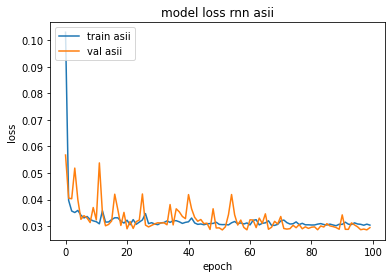

In [49]:
import matplotlib.pyplot as plt
plt.plot(smod_history_rnn_one_asii.history['loss'])
plt.plot(smod_history_rnn_one_asii.history['val_loss'])
plt.title('model loss rnn asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train asii', 'val asii'], loc='upper left')
plt.savefig('rnn_one_asii',dpi=1200)
plt.show()

### ICBP

In [33]:
import random
random.seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

simple_model_rnn_one_icbp = Sequential([
  SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_icbp.shape[1]),
])


simple_model_rnn_one_icbp.summary()

simple_model_rnn_one_icbp.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_rnn_one_icbp = simple_model_rnn_one_icbp.fit(X_train_rs_icbp, y_train_icbp,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

preds_rnn_one_icbp = simple_model_rnn_one_icbp.predict(X_test_rs_icbp)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_6 (Dense)             (None, 6)                 54        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 [==============================] - 1s 8ms/step - loss: 0.0966 - mean_absolute_error: 0.0966 - val_loss: 0.0252 - val_mean_absolute_error: 0.0252
Epoch 2/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0197 - mean_absolute_error: 0.0197 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187
Epoch 3/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0181 - mean_absolute_error: 0.0181 - val_loss: 0.01

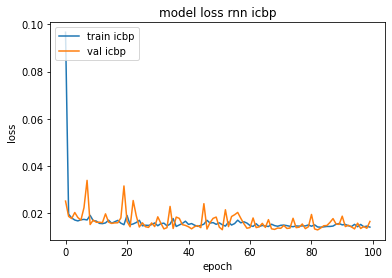

In [48]:
import matplotlib.pyplot as plt
plt.plot(smod_history_rnn_one_icbp.history['loss'])
plt.plot(smod_history_rnn_one_icbp.history['val_loss'])
plt.title('model loss rnn icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train icbp', 'val icbp'], loc='upper left')
plt.savefig('rnn_one_icbp',dpi=1200)
plt.show()

### JSMR

In [35]:
import random
random.seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

simple_model_rnn_one_jsmr = Sequential([
  SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_jsmr.shape[1]),
])


simple_model_rnn_one_jsmr.summary()

simple_model_rnn_one_jsmr.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_rnn_one_jsmr = simple_model_rnn_one_jsmr.fit(X_train_rs_jsmr, y_train_jsmr,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

preds_rnn_one_jsmr = simple_model_rnn_one_jsmr.predict(X_test_rs_jsmr)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_7 (Dense)             (None, 6)                 54        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 [==============================] - 1s 8ms/step - loss: 0.1546 - mean_absolute_error: 0.1546 - val_loss: 0.1023 - val_mean_absolute_error: 0.1023
Epoch 2/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0451 - mean_absolute_error: 0.0451 - val_loss: 0.0453 - val_mean_absolute_error: 0.0453
Epoch 3/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.05

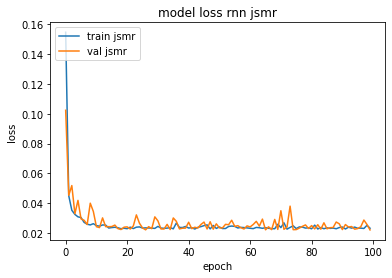

In [47]:
import matplotlib.pyplot as plt
plt.plot(smod_history_rnn_one_jsmr.history['loss'])
plt.plot(smod_history_rnn_one_jsmr.history['val_loss'])
plt.title('model loss rnn jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train jsmr', 'val jsmr'], loc='upper left')
plt.savefig('rnn_one_jsmr',dpi=1200)
plt.show()

### MODEL LOSS COMPARISON

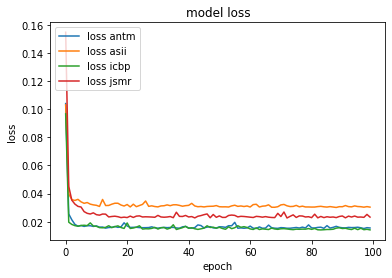

In [56]:
plt.plot(smod_history_rnn_one_antm.history['loss'], label='loss antm')
plt.plot(smod_history_rnn_one_asii.history['loss'], label = 'loss asii')
plt.plot(smod_history_rnn_one_icbp.history['loss'], label = 'loss icbp' )
plt.plot(smod_history_rnn_one_jsmr.history['loss'], label = 'loss jsmr')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('rnn_loss_comparison_1layer')

## COMPARISON MODEL LOSS LSTM AND RNN

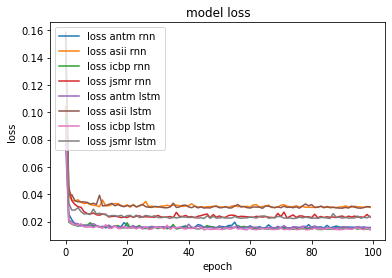

In [45]:
plt.plot(smod_history_rnn_one_antm.history['loss'], label='loss antm rnn')
plt.plot(smod_history_rnn_one_asii.history['loss'], label = 'loss asii rnn')
plt.plot(smod_history_rnn_one_icbp.history['loss'], label = 'loss icbp rnn' )
plt.plot(smod_history_rnn_one_jsmr.history['loss'], label = 'loss jsmr rnn')
plt.plot(smod_history_one_antm.history['loss'], label='loss antm lstm')
plt.plot(smod_history_one_asii.history['loss'], label = 'loss asii lstm')
plt.plot(smod_history_one_icbp.history['loss'], label = 'loss icbp lstm' )
plt.plot(smod_history_one_jsmr.history['loss'], label = 'loss jsmr lstm')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('rnn_loss_comparison_1layer')

### METRICS EVALUATION

#### MAE

In [40]:
from sklearn.metrics import mean_absolute_error

# R2 score
print("mae score antm: "+str(mean_absolute_error(preds_rnn_one_antm, y_test_antm).round(2)))
print("mae score asii: "+str(mean_absolute_error(preds_rnn_one_asii, y_test_asii).round(2)))
print("mae score icbp: "+str(mean_absolute_error(preds_rnn_one_icbp, y_test_icbp).round(2)))
print("mae score jsmr: "+str(mean_absolute_error(preds_rnn_one_jsmr, y_test_jsmr).round(2)))


mae score antm: 0.02
mae score asii: 0.03
mae score icbp: 0.02
mae score jsmr: 0.02


#### MAPE

In [41]:
from sklearn.metrics import mean_absolute_percentage_error
# Forecast
# mape score
print("mape score antm: "+str(mean_absolute_percentage_error(preds_rnn_one_antm, y_test_antm).round(2)))
print("mape score asii: "+str(mean_absolute_percentage_error(preds_rnn_one_asii, y_test_asii).round(2)))
print("mape score icbp: "+str(mean_absolute_percentage_error(preds_rnn_one_icbp, y_test_icbp).round(2)))
print("mape score jsmr: "+str(mean_absolute_percentage_error(preds_rnn_one_jsmr, y_test_jsmr).round(2)))

mape score antm: 0.3
mape score asii: 0.07
mape score icbp: 0.14
mape score jsmr: 0.05


In [42]:
from sklearn.metrics import r2_score

# R2 score
print("r2 score antm: "+str(r2_score(preds_rnn_one_antm, y_test_antm).round(2)))
print("r2 score asii: "+str(r2_score(preds_rnn_one_asii, y_test_asii).round(2)))
print("r2 score icbp: "+str(r2_score(preds_rnn_one_icbp, y_test_icbp).round(2)))
print("r2 score jsmr: "+str(r2_score(preds_rnn_one_jsmr, y_test_jsmr).round(2)))


r2 score antm: 0.98
r2 score asii: 0.96
r2 score icbp: 0.99
r2 score jsmr: 0.98


# ARIMA

### GET THE DATA

In [ ]:
#Saham yang akan dimodelkan
#,"ASII.JK","ICBP.JK","JSMR.JK"
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]
#range dari tanggal yang dibutuhkan
today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = today
# end_date = '2022-03-10'
#ambil data
panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)
data_close = panel_data["Close"]
data_close.head(5).round(2)
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close


,antm,asii,icbp,jsmr
Date,,,,
2010-01-04,1931.946777,3530.0,1837.5,1845.677368
2010-01-05,1931.946777,3550.0,1875.0,1865.630737
2010-01-06,1931.946777,3530.0,1862.5,1875.607300
2010-01-07,1973.945557,3420.0,1875.0,1865.630737
2010-01-08,1973.945557,3440.0,1887.5,1855.654053
...,...,...,...,...
2022-06-13,2260.000000,7025.0,8600.0,3810.000000
2022-06-14,2180.000000,6975.0,8650.0,3880.000000
2022-06-15,2170.000000,6700.0,8600.0,3750.000000


In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

### ANTM (NON-STASIONER)

In [ ]:
df_antm = data_close['antm']
df_antm

Date
2010-01-04    1931.946777
2010-01-05    1931.946777
2010-01-06    1931.946777
2010-01-07    1973.945557
2010-01-08    1973.945557
                 ...     
2022-06-13    2260.000000
2022-06-14    2180.000000
2022-06-15    2170.000000
2022-06-16    2150.000000
2022-06-17    2110.000000
Name: antm, Length: 3085, dtype: float64

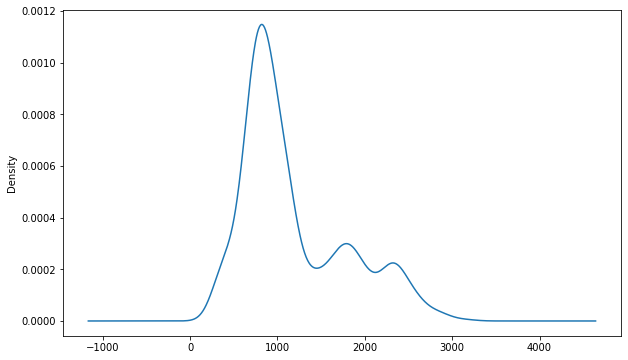

In [ ]:
#Distribution of the dataset
df_antm.plot(kind='kde')

#### STATIONARY TEST

Results of dickey fuller test
Test Statistics                  -1.761808
p-value                           0.399581
No. of lags used                 21.000000
Number of observations used    3063.000000
critical value (1%)              -3.432487
critical value (5%)              -2.862484
critical value (10%)             -2.567273
dtype: float64


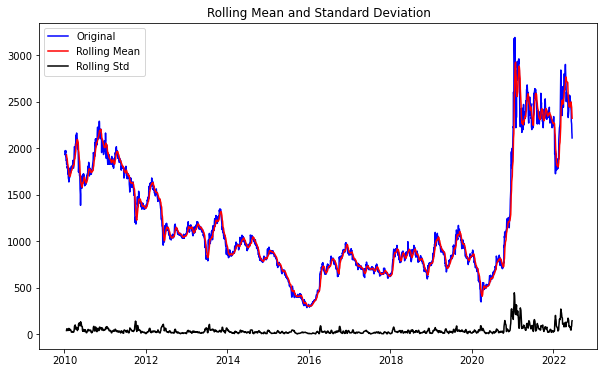

In [ ]:
test_stationarity(df_antm)

#### SEASONAL DECOMPOSE

<Figure size 864x432 with 0 Axes>

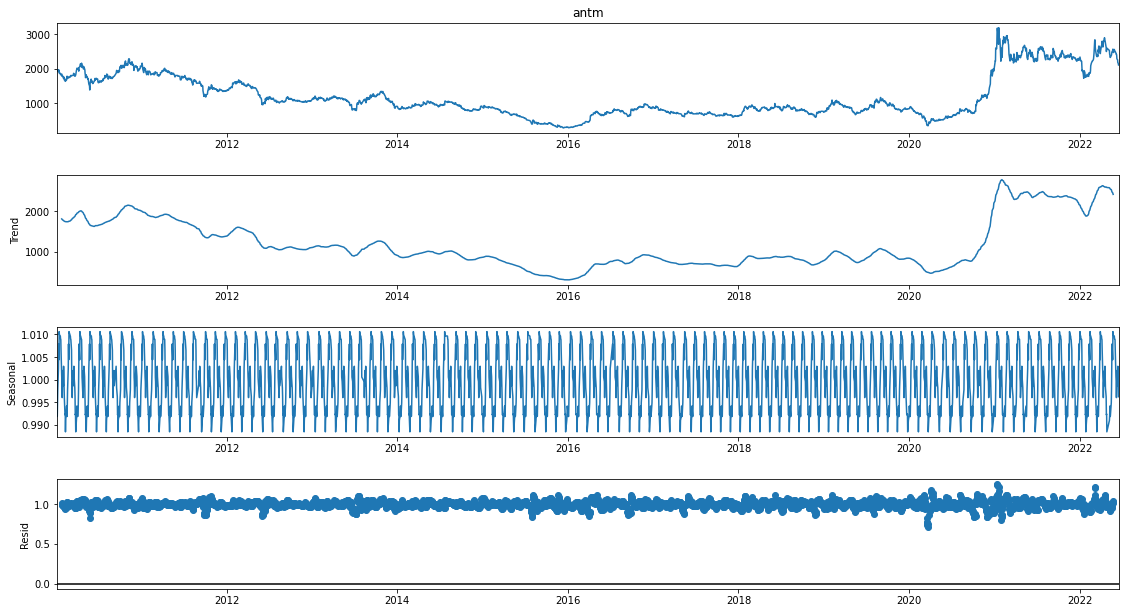

In [ ]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result_antm = seasonal_decompose(df_antm, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result_antm.plot()  
fig.set_size_inches(16, 9)

#### ELIMINATE TREND

No handles with labels found to put in legend.


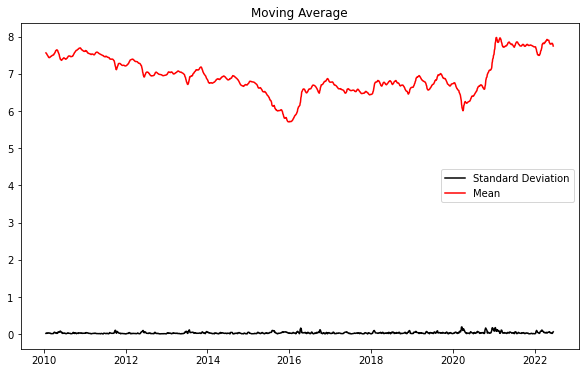

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log_antm = np.log(df_antm)
moving_avg = df_log_antm.rolling(12).mean()
std_dev = df_log_antm.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

#### SPLIT DATA TO TRAIN AND TEST

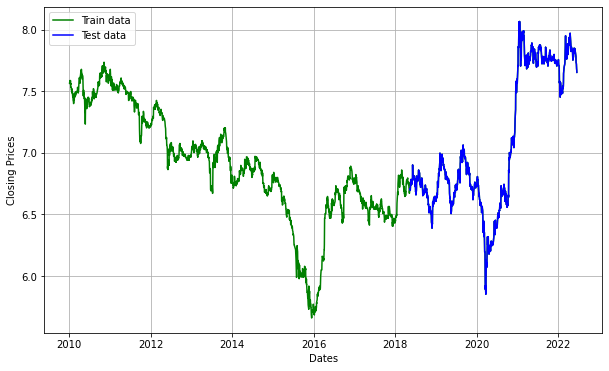

In [ ]:
#split data into train and training set
train_data_antm, test_data_antm = df_log_antm[3:int(len(df_log_antm)*0.33)], df_log_antm[int(len(df_log_antm)*0.67):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log_antm, 'green', label='Train data')
plt.plot(test_data_antm, 'blue', label='Test data')
plt.legend()

#### AUTO ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6904.540, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4737.740, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4717.990, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4733.869, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4743.100, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1084.467, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4740.002, Time=2.94 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-4741.178, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=184.444, Time=

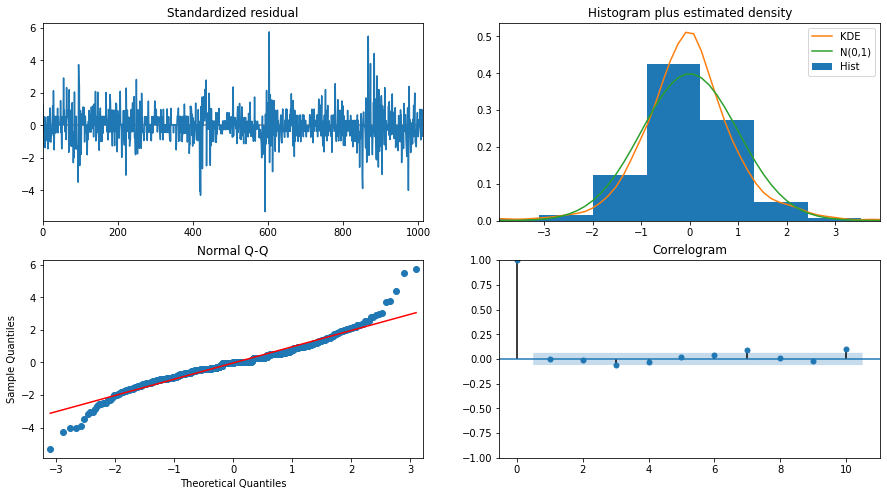

In [ ]:
model_autoARIMA_antm = auto_arima(train_data_antm, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_antm.summary())
model_autoARIMA_antm.plot_diagnostics(figsize=(15,8))
plt.show()

#### MODELING

In [ ]:
#Modeling
# Build Model
model_ARIMA_antm = ARIMA(train_data_antm, order=(1,0,1))  
fitted_antm = model_ARIMA_antm.fit()  
print(fitted_antm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   antm   No. Observations:                 1015
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2375.544
Date:                Fri, 17 Jun 2022   AIC                          -4743.087
Time:                        10:13:00   BIC                          -4723.397
Sample:                             0   HQIC                         -4735.609
                               - 1015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.2426      0.173     41.823      0.000       6.903       7.582
ar.L1          0.9969      0.003    390.031      0.000       0.992       1.002
ma.L1         -0.0025      0.022     -0.111      0.9

#### FORECASTING

In [ ]:
#  Make as pandas series
# fc_series = pd.Series(fc, index=test_data.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
# # Plot
# plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data, label='training data')
# plt.plot(test_data, color = 'blue', label='Actual Stock Price')
# plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
# plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('ARCH CAPITAL GROUP Stock Price')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

In [ ]:
# Forecast

fc_antm = fitted_antm.forecast(len(test_data_antm), alpha=0.05)  # 95% conf

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


#### METRIC EVALUATION

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# report performance
mae = mean_absolute_error(test_data_antm, fc_antm)
print('MAE: '+str(mae))
mape = mean_absolute_percentage_error(test_data_antm,fc_antm)
print('MAPE: '+str(mape))


MAE: 0.4323564671943776
MAPE: 0.06120665476067486


### ASII (STASIONER)

In [ ]:
df_asii = data_close['asii']
df_asii

Date
2010-01-04    3530.0
2010-01-05    3550.0
2010-01-06    3530.0
2010-01-07    3420.0
2010-01-08    3440.0
               ...  
2022-06-13    7025.0
2022-06-14    6975.0
2022-06-15    6700.0
2022-06-16    6850.0
2022-06-17    6950.0
Name: asii, Length: 3085, dtype: float64

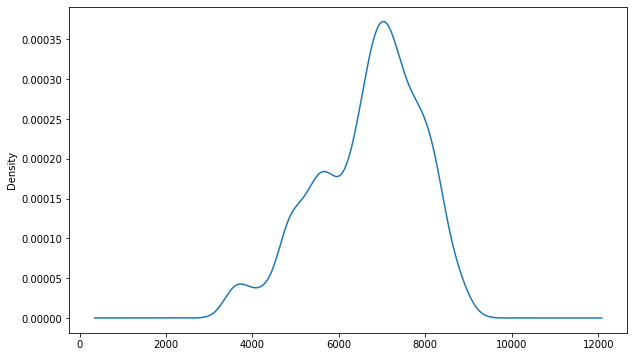

In [ ]:
#Distribution of the dataset
df_asii.plot(kind='kde')

#### STATIONARY TEST (STASIONER)

Results of dickey fuller test
Test Statistics                  -3.233834
p-value                           0.018108
No. of lags used                  6.000000
Number of observations used    3078.000000
critical value (1%)              -3.432476
critical value (5%)              -2.862479
critical value (10%)             -2.567270
dtype: float64


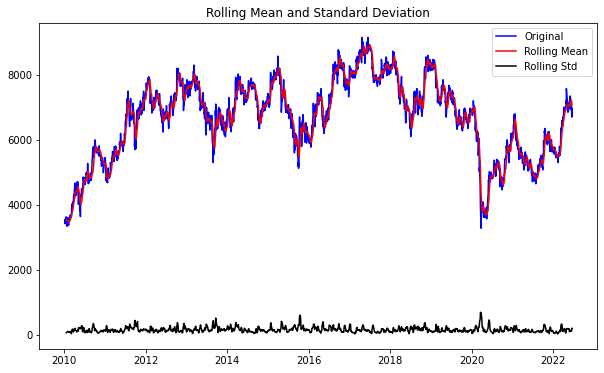

In [ ]:
test_stationarity(df_asii)

#### TRANSFORMING DATA TO ELIMINATE TREND

No handles with labels found to put in legend.


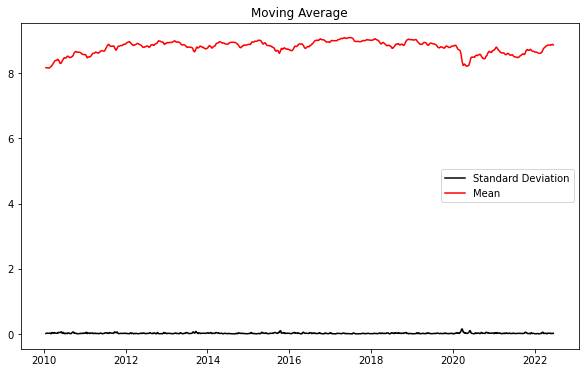

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log_asii = np.log(df_asii)
moving_avg = df_log_asii.rolling(12).mean()
std_dev = df_log_asii.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

#### SPLIT TO TRAIN AND TEST

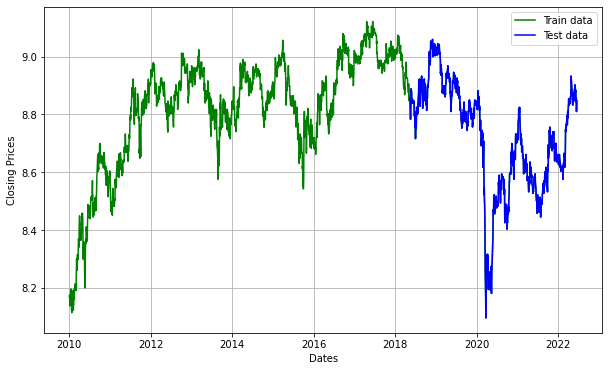

In [ ]:
#split data into train and training set
train_data_asii, test_data_asii = df_log_asii[3:int(len(df_log_asii)*0.33)], df_log_asii[int(len(df_log_asii)*0.67):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log_asii, 'green', label='Train data')
plt.plot(test_data_asii, 'blue', label='Test data')
plt.legend()

#### AUTO ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4884.283, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4882.554, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4882.572, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4885.307, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4880.563, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.051 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1015
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2443.653
Date:                Fri, 17 Jun 2022   AIC                          -4885.307
Time:                        10:42:44   BIC                          -4880.385
Sample:                             0   HQIC                         -4883.437
                               - 1015                                  

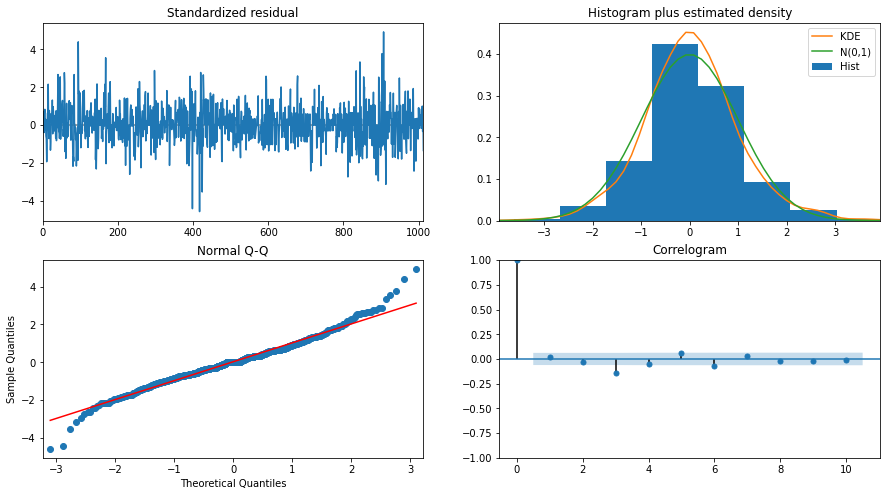

In [ ]:
model_autoARIMA_asii = auto_arima(train_data_asii, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_asii.summary())
model_autoARIMA_asii.plot_diagnostics(figsize=(15,8))
plt.show()

#### MODELING

In [ ]:
#Modeling
# Build Model
model_ARIMA_asii = ARIMA(train_data_asii, order=(0,1,0))  
fitted_asii = model_ARIMA_asii.fit()  
print(fitted_asii.summary())

                               SARIMAX Results                                
Dep. Variable:                   asii   No. Observations:                 1015
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2443.653
Date:                Fri, 17 Jun 2022   AIC                          -4885.307
Time:                        10:42:50   BIC                          -4880.385
Sample:                             0   HQIC                         -4883.437
                               - 1015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   1.48e-05     32.004      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               177.38
Prob(Q):                              0.60   Pr

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#### FORECASTING & METRIC EVALUATION

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
# Forecast

fc_asii = fitted_asii.forecast(len(test_data_asii), alpha=0.05)  # 95% conf
# report performance
mae = mean_absolute_error(test_data_asii, fc_asii)
print('MAE: '+str(mae))
mape = mean_absolute_percentage_error(test_data_asii,fc_asii)
print('MAPE: '+str(mape))


MAE: 0.16178383371475763
MAPE: 0.018829002850216593


### ICBP

In [ ]:
df_icbp = data_close['icbp']
df_icbp

Date
2010-01-04    1837.5
2010-01-05    1875.0
2010-01-06    1862.5
2010-01-07    1875.0
2010-01-08    1887.5
               ...  
2022-06-13    8600.0
2022-06-14    8650.0
2022-06-15    8600.0
2022-06-16    8675.0
2022-06-17    8550.0
Name: icbp, Length: 3085, dtype: float64

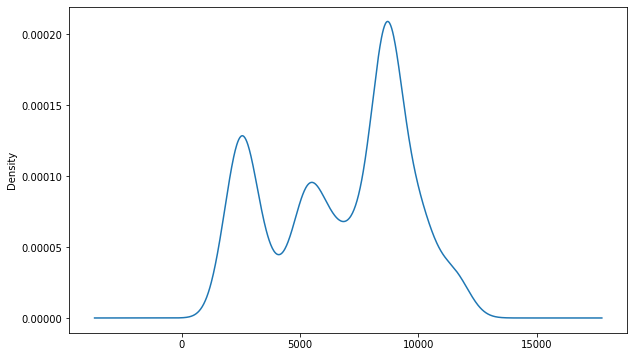

In [ ]:
#Distribution of the dataset
df_icbp.plot(kind='kde')

#### STATIONARY TEST

Results of dickey fuller test
Test Statistics                  -1.608241
p-value                           0.479453
No. of lags used                 13.000000
Number of observations used    3071.000000
critical value (1%)              -3.432481
critical value (5%)              -2.862482
critical value (10%)             -2.567271
dtype: float64


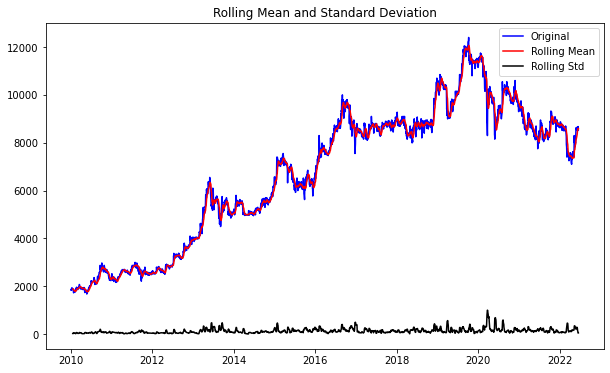

In [ ]:
test_stationarity(df_icbp)

#### TRANSFORMING DATA TO ELIMINATE TREND

No handles with labels found to put in legend.


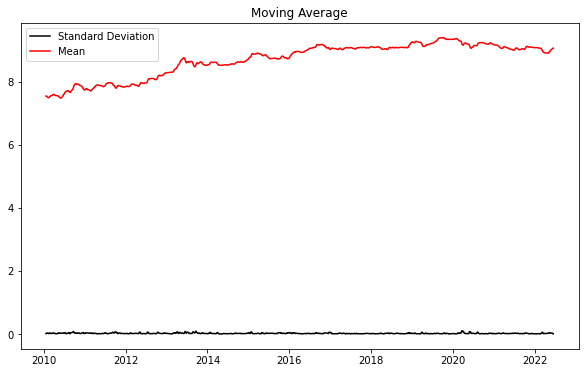

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log_icbp = np.log(df_icbp)
moving_avg = df_log_icbp.rolling(12).mean()
std_dev = df_log_icbp.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

#### SPLIT DATA TO TRAIN/TEST

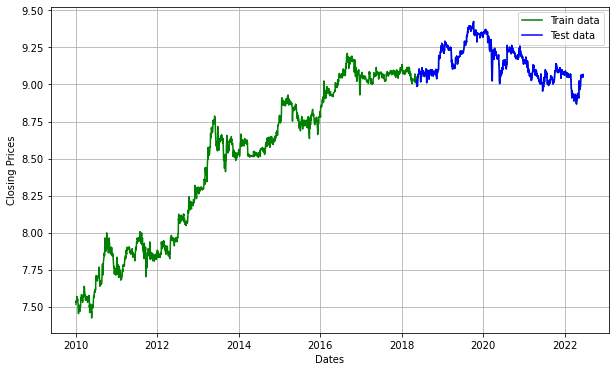

In [ ]:
#split data into train and training set
train_data_icbp, test_data_icbp = df_log_icbp[3:int(len(df_log_icbp)*0.33)], df_log_icbp[int(len(df_log_icbp)*0.67):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log_icbp, 'green', label='Train data')
plt.plot(test_data_icbp, 'blue', label='Test data')
plt.legend()

#### AUTO ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4836.137, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4836.875, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4836.837, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4835.754, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4834.979, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4836.361, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4832.938, Time=2.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4836.245, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 5.602 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1015
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2421.438
Date:                Fri, 17 Jun 2022   AIC                          -4836.875
Time:                       

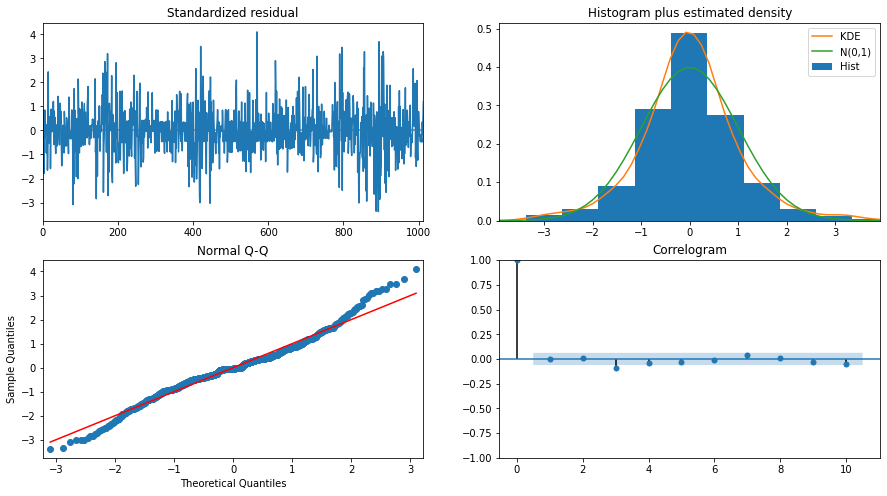

In [ ]:
model_autoARIMA_asii = auto_arima(train_data_asii, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_asii.summary())
model_autoARIMA_asii.plot_diagnostics(figsize=(15,8))
plt.show()

#### MODELING

In [ ]:
#Modeling
# Build Model
model_ARIMA_icbp = ARIMA(train_data_icbp, order=(1,1,0))  
fitted_icbp = model_ARIMA_icbp.fit()  
print(fitted_icbp.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   icbp   No. Observations:                 1015
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2420.123
Date:                Fri, 17 Jun 2022   AIC                          -4836.245
Time:                        10:46:34   BIC                          -4826.402
Sample:                             0   HQIC                         -4832.507
                               - 1015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0496      0.025     -2.015      0.044      -0.098      -0.001
sigma2         0.0005   1.64e-05     30.233      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

#### FORECASTING AND METRIC EVALUATION

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
# Forecast

fc_icbp = fitted_icbp.forecast(len(test_data_icbp), alpha=0.05)  # 95% conf
# report performance
mae = mean_absolute_error(test_data_icbp, fc_icbp)
print('MAE: '+str(mae))
mape = mean_absolute_percentage_error(test_data_icbp,fc_icbp)
print('MAPE: '+str(mape))


MAE: 0.5209866400765537
MAPE: 0.056781742965607056


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


## JSMR

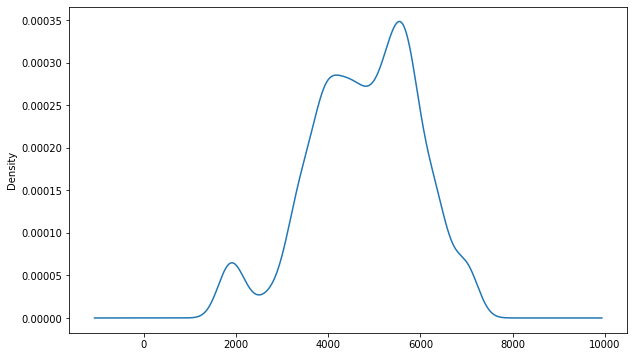

In [ ]:
df_jsmr = data_close['jsmr']
#Distribution of the dataset
df_jsmr.plot(kind='kde')

#### STATIONARY TEST

Results of dickey fuller test
Test Statistics                  -2.709887
p-value                           0.072343
No. of lags used                  3.000000
Number of observations used    3081.000000
critical value (1%)              -3.432474
critical value (5%)              -2.862479
critical value (10%)             -2.567270
dtype: float64


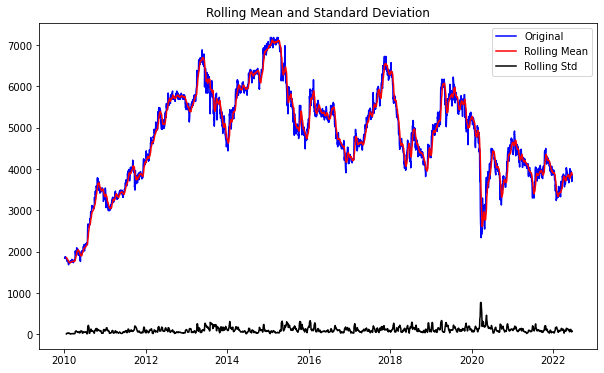

In [ ]:
test_stationarity(df_jsmr)

#### TRANSFORMING DATA TO ELIMINATE TRENDS

No handles with labels found to put in legend.


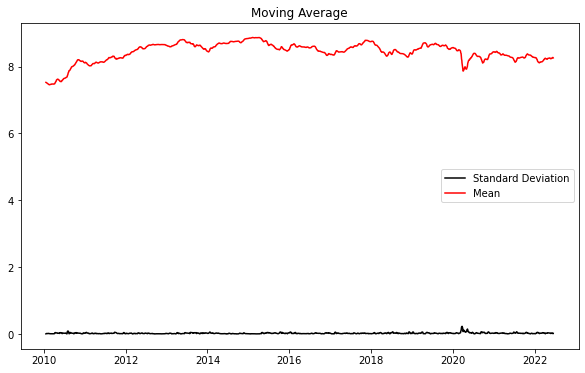

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log_jsmr = np.log(df_jsmr)
moving_avg = df_log_jsmr.rolling(12).mean()
std_dev = df_log_jsmr.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

#### SPLIT DATA TO TRAIN/TEST

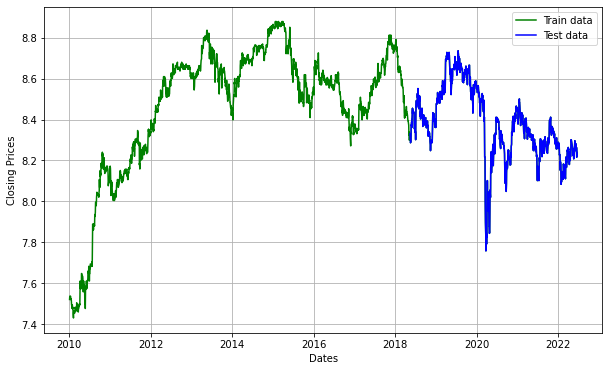

In [ ]:
#split data into train and training set
train_data_jsmr, test_data_jsmr = df_log_jsmr[3:int(len(df_log_jsmr)*0.33)], df_log_jsmr[int(len(df_log_jsmr)*0.67):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log_jsmr, 'green', label='Train data')
plt.plot(test_data_jsmr, 'blue', label='Test data')
plt.legend()

#### AUTO ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5159.483, Time=0.80 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5157.606, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5157.610, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5158.352, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5155.484, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.375 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1015
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2581.742
Date:                Fri, 17 Jun 2022   AIC                          -5159.483
Time:                        10:50:52   BIC                          -5149.640
Sample:                             0   HQIC                         -5155.745
                               - 1015                                  

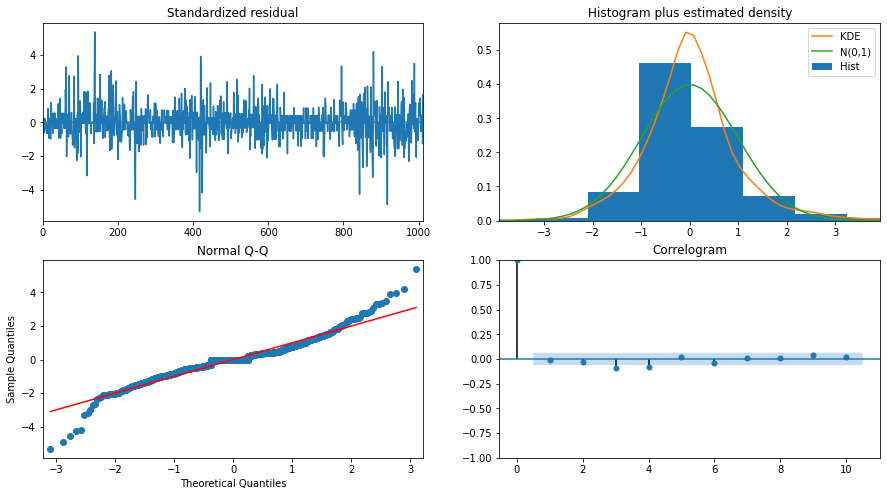

In [ ]:
model_autoARIMA_jsmr = auto_arima(train_data_jsmr, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_jsmr.summary())
model_autoARIMA_jsmr.plot_diagnostics(figsize=(15,8))
plt.show()

#### MODELING

In [ ]:
#Modeling
# Build Model
model_ARIMA_jsmr = ARIMA(train_data_jsmr, order=(0,1,0))  
fitted_jsmr = model_ARIMA_jsmr.fit()  
print(fitted_jsmr.summary())

                               SARIMAX Results                                
Dep. Variable:                   jsmr   No. Observations:                 1015
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2580.176
Date:                Fri, 17 Jun 2022   AIC                          -5158.352
Time:                        10:51:04   BIC                          -5153.430
Sample:                             0   HQIC                         -5156.482
                               - 1015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004    9.2e-06     39.198      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               698.26
Prob(Q):                              0.73   Pr

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#### FORECASTING AND METRIC EVALUATION

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
# Forecast

fc_jsmr = fitted_jsmr.forecast(len(test_data_jsmr), alpha=0.05)  # 95% conf
# report performance
mae = mean_absolute_error(test_data_jsmr, fc_jsmr)
print('MAE: '+str(mae))
mape = mean_absolute_percentage_error(test_data_jsmr,fc_jsmr)
print('MAPE: '+str(mape))


MAE: 0.2361891509041422
MAPE: 0.028567055918692554


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
